In [1]:
import os, sys

import numpy as np

import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from matplotlib.colors import LogNorm
from matplotlib.colors import LinearSegmentedColormap
from mpl_toolkits.axes_grid1 import make_axes_locatable 

import scipy as sp

sys.path.append("../../libs/global_chanju")

# Figure styles
from global_chanju.paulplot.styles import nice_style
from global_chanju.paulplot.styles import base_ten
from global_chanju.paulplot.rc_setter import set_rc
from global_chanju.paulplot.rc_setter import get_rc
from global_chanju.utils.statistics import f_bin
from global_chanju.utils.statistics import asym_err

In [2]:
# Set default aspect ratio
set_rc()

In [ ]:
# Input parameters
vareps = 1e-15

n_seed = 10

dim_in = 3
dim_out = 1
r = 2
K = 16
bs = 4
epochs = 100000
n_save = 21

actfid = "tanh"

identifier = "fixed_eps_Ttf"

In [3]:
# Set data directory

project_name = "r%dK%d"%(r, K)

plot_dir = "../../data_assets/figures/"
os.system("mkdir -p "+plot_dir)

model_dir_base = "../../data/"+identifier+'/'
model_batch_dir = [model_dir_base+'/'+x+'/'+project_name+'/' for x in os.listdir(model_dir_base) if x[0]=='f']

data_names = []
n_sb = len(model_batch_dir)

for i in range(n_sb):
    try:
        data_list = [model_batch_dir[i]+'/'+x for x in os.listdir(model_batch_dir[i]) if x[0] == 'r']
        data_names.append(data_list)
    except:
        continue
    
data_names = [ x for xs in data_names for x in xs ]

data_names.sort(key=lambda s: int(s.split(identifier)[2][0]))
data_names.sort(key=lambda s: float(s.split('/')[-1].split("eps")[1]))
data_names.sort(key=lambda s: float(s.split('/')[-1].split("lr")[1].split('_')[0]))

lrs = []
epss = []
for n in data_names:
    seed_ = int(n.split(identifier)[2][0])
    eps_ = float(n.split('/')[-1].split("eps")[1])
    lr_ = float(n.split('/')[-1].split("lr")[1].split('_')[0])
    lrs.append(lr_)
    epss.append(eps_)
    
lrs = np.unique(lrs)
epss = np.unique(epss)
n_lr = len(lrs)
n_eps = len(epss)
print(lrs)
print(epss)


# Network structure

if actfid == "tanh":
    # Tanh
    actf = lambda x: np.tanh(x)
    actdf = lambda x: 1 - np.tanh(x)**2
    
elif actfid == "identity":
    # Identity
    actf = lambda x: x
    actdf = lambda x: np.ones_like(x)
    
elif actfid == "relu":
    # ReLU
    actf = lambda x: x * (x > 0)
    actdf = lambda x: 1. * (x > 0)
    
else:
    raise ValueError("Undefined actfid")

[1.25e-01 2.50e-01 5.00e-01 1.00e+00 2.00e+00 4.00e+00 8.00e+00 1.60e+01
 3.20e+01 6.40e+01 1.28e+02 2.56e+02]
[1.25e-01 2.50e-01 5.00e-01 1.00e+00 2.00e+00 4.00e+00 8.00e+00 1.60e+01
 3.20e+01 6.40e+01 1.28e+02 2.56e+02]


In [8]:
# Load dataset

datas= []
names = []
for i in range(n_lr):
    for j in range(n_eps):
        for n in range(n_sb):
            data_name = data_names[n + n_sb*j + n_sb*n_eps*i] + '/'+'data.npz'
            datas.append(np.load(data_name, allow_pickle=True))
            names.append(data_name)
print("Total models: ", len(datas))
print("Number of model matchs loaded models: ", n_lr * n_eps * n_sb == len(datas))

datas[0]['arr_0'].item().keys()
n_data = n_sb * n_seed

W_data = np.empty((n_data, n_eps, n_lr, n_save, K, r*K))
dW_data = np.empty((n_data, n_eps, n_lr, n_save, K, r*K))
loss_data = np.empty((n_data, n_eps, n_lr, n_save))
Wt_data = np.empty((n_data, n_eps, n_lr, K, r*K))
Z_data = np.empty((n_data, n_eps, n_lr, dim_out, K))
M_data = np.empty((n_data, n_eps, n_lr, r*K, dim_in))
el_data = np.empty((n_eps, n_lr, 2))

print("Loading data")
for i in range(n_lr):
    for j in range(n_eps):
        for n in range(n_sb):
            W_ = datas[n + n_sb*j + n_sb*n_eps*i]['arr_0'].item()['W'][:n_seed]
            W_data[n*n_seed:(n+1)*n_seed,j,i] = W_
            dW_data[n*n_seed:(n+1)*n_seed,j,i] = datas[n + n_sb*j + n_sb*n_eps*i]['arr_0'].item()['dW'][:n_seed]
            loss_data[n*n_seed:(n+1)*n_seed,j,i] = datas[n + n_sb*j + n_sb*n_eps*i]['arr_0'].item()['loss'][:n_seed]
            Wt_ = datas[n + n_sb*j + n_sb*n_eps*i]['arr_0'].item()['Wt'][:n_seed]
            Wt_data[n*n_seed:(n+1)*n_seed,j,i] = Wt_
            Z_data[n*n_seed:(n+1)*n_seed,j,i] = datas[n + n_sb*j + n_sb*n_eps*i]['arr_0'].item()['Z'][:n_seed]
            M_data[n*n_seed:(n+1)*n_seed,j,i] = datas[n + n_sb*j + n_sb*n_eps*i]['arr_0'].item()['M'][:n_seed]

            lr_ = float(data_names[n + n_sb*j + n_sb*n_eps*i].split("lr")[1].split('_')[0])
            eps_ = float(data_names[n + n_sb*j + n_sb*n_eps*i].split("eps")[-1].split('/')[0])
            seed_ = int(data_names[n + n_sb*j + n_sb*n_eps*i].split(identifier)[2][0])
            el_data[j,i] = [1./eps_ , lr_/bs]
#             print("batch: %d, eps: %.3f, lr: %.3f"%(seed_, eps_, lr_))

print("Done")

Total models:  1440
Number of model matchs loaded models:  True
Loading data
Done


In [9]:
# Measure observables

n_test = 128
np.random.seed(42)

x_test = np.random.normal(0., 1., size=(n_test, dim_in))
s0 = np.tanh(np.einsum("selKi, ni -> selnK", M_data, x_test))
st = np.tanh(np.einsum("selLK, selnK -> selnL", Wt_data, s0))
W_last = W_data[:,:,:,-1]
s_ = np.einsum("selLK, selnK -> selnL", W_last, s0)
s_init = np.tanh(np.einsum("selLK, selnK -> selnL", W_data[:,:,:,0], s0))
s = np.tanh(s_)
yt = np.einsum("seloL, selnL -> selno", Z_data, st)
y = np.einsum("seloL, selnL -> selno", Z_data, s)
sigp = actdf(s_)

yt_y = yt - y
phi = np.einsum("selno, seloL, selnL -> selnL", yt_y, Z_data, sigp)
grad = np.einsum("selnL, selnK -> selnLK", phi, s0)

dX_l = np.einsum("selaK, selnbK -> selnab", W_last, grad)
dX = dX_l + np.transpose(dX_l, axes=(0,1,2,3,5,4))
K_ab = np.mean(dX, axis=3)
V_ab = np.var(dX, axis=3)
X = np.einsum("selLK, selaK -> selLa", W_last, W_last)
U, x, _ = np.linalg.svd(X)
K_til = np.einsum("selba, selbc, selcd -> selad", U, K_ab, U)
V_til = np.einsum("selba, selbc, selcd -> selad", U, V_ab, U)

StN = np.empty((n_data, n_eps, n_lr))
K_t = np.empty((n_data, n_eps, n_lr))
V_t = np.empty((n_data, n_eps, n_lr))
for i in range(n_eps):
    for j in range(n_lr):
        diag_ = np.abs(np.diagonal(K_til[:, i, j], axis1=-1, axis2=-2))
        K_t[:, i, j] = diag_[:, 0] - diag_[:, -1]

        H_n = 0.
        for k in range(1, K - 1):
            H_n += (V_til[:, i, j, 0, k] + V_til[:, i, j, -1, K - k]) / k
        V_t[:, i, j] = 2.*V_til[:, i, j, 0, -1] / (K - 1.) + H_n
        StN[:, i, j] = K_t[:, i, j] / (V_t[:, i, j] + vareps)
        
limit_matrix_new = np.zeros((n_eps, n_lr))

for i in range(n_eps):
    for j in range(n_lr):
        limit_matrix_new[i, j] = np.mean(K_t[:, i, j] / np.sqrt(r) / (K - 1.) >= (lrs[j] / bs) * V_t[:, i, j] / (epss[i])**2 / 4.) 

q_time = np.einsum("selni, selni -> sel", s_init, s) / n_test / K

h = np.einsum("selno, seloi -> selni", yt, Z_data)
normh = h / np.linalg.norm(h, axis=(-1, -2), keepdims=True)
norms = s / np.linalg.norm(s, axis=(-1, -2), keepdims=True)
hs = np.einsum("selni, selni -> sel", normh, norms) / n_test

print("Done")

# Figure 1

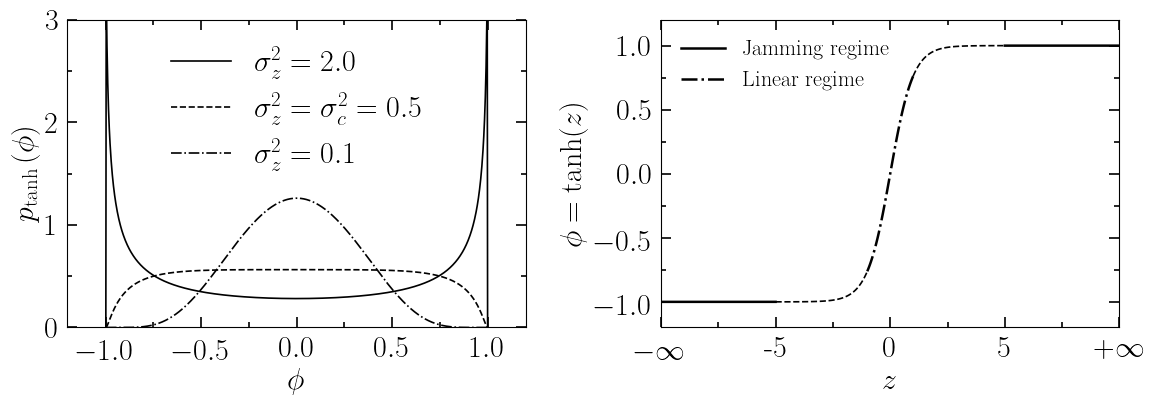

In [10]:
set_rc(scale=1.2)

def py(y, sig):
    return np.where(np.abs(y) < 0.999, np.exp(-0.5*np.arctanh(y)**2 / sig**2) / (1. - (y)**2) / np.sqrt(2.* np.pi * sig**2), 0)

n_fig=2
fig, axs = plt.subplots(1, n_fig, figsize=(n_fig*get_rc()['W'], get_rc()['W']*get_rc()['r']))

y_support = np.linspace(-0.999,0.999,1000)
axs[0].plot(y_support, py(y_support, np.sqrt(2.0)), 
            c='k', label=r"$\sigma_z^2 = 2.0$", marker='')
axs[0].plot(y_support, py(y_support, np.sqrt(0.5)), 
            c='k', label=r"$\sigma_z^2 = \sigma_c^2 = 0.5 $", marker='')
axs[0].plot(y_support, py(y_support, np.sqrt(0.1)), 
            c='k', label=r"$\sigma_z^2 = 0.1$", marker='')

nice_style(axs[0], 
           xlim=(-1.2,1.2), ylim=(0,3),
           xlabel=r"$\phi$", ylabel=r"$p_{\tanh} \left(\phi\right)$"
          )


axs[0].legend(loc="upper center")

x_plot = np.linspace(-10,-5,100)
y_plot = np.tanh(x_plot)
axs[1].plot(x_plot, y_plot, 
            c='k', ls='-', marker='', lw=1.8, 
            label=r"Jamming regime")

x_plot = np.linspace(5,10,100)
y_plot = np.tanh(x_plot)
axs[1].plot(x_plot, y_plot, c='k', ls='-', marker='', lw=1.8)

x_plot = np.linspace(-5,-1,100)
y_plot = np.tanh(x_plot)
axs[1].plot(x_plot, y_plot, c='k', ls='--', marker='')

x_plot = np.linspace(1,5,100)
y_plot = np.tanh(x_plot)
axs[1].plot(x_plot, y_plot, c='k', ls='--', marker='')

x_plot = np.linspace(-1,1,100)
y_plot = np.tanh(x_plot)
axs[1].plot(x_plot, y_plot, 
            c='k', ls='-.', marker='', lw=1.8, 
            label=r"Linear regime")

ytik = [-1, -0.5, 0, 0.5, 1]
xtik = [-10, -5, 0, 5, 10]
xlab = [r"$-\infty$", "-5", "0", "5", r"$+\infty$"]

nice_style(axs[1], 
           xlim=(-10,10), ylim=(-1.2,1.2),
           xticks=xtik, xtick_label=xlab,
           yticks=ytik,
           xlabel=r"$z$", ylabel=r"$\phi = \tanh(z)$",
          )

axs[1].legend(loc = "upper left", fontsize=16)

plt.savefig(plot_dir+'tanh.pdf')

plt.show()

# Figure 2

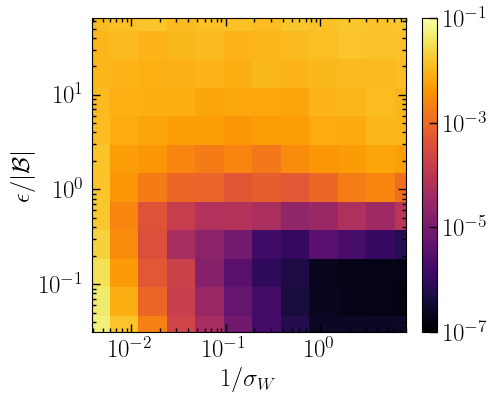

In [11]:
set_rc(scale=1)

loss_test = np.mean((yt - y)**2, axis=(-2, -1))

n_fig = 1
fig, axs = plt.subplots(1, n_fig, figsize=(n_fig*get_rc()['W']*get_rc()['r'], get_rc()['W']*get_rc()['r']))

im = axs.pcolor(el_data[:, :, 0], el_data[:, :, 1], 
                np.mean(loss_test, axis=(0)),
                norm=LogNorm(vmin=1e-7, vmax=1e-1),
                cmap='inferno')

nice_style(axs, 
           ylim=(np.min(el_data[0,:,1]), np.max(el_data[0,:,1])),
           xlim=(np.min(el_data[:,0,0]), np.max(el_data[:,0,0])),
           xlabel=r"$1/\sigma_W$",
           ylabel=r"$\epsilon / |\mathcal{B}|$",
           logx=True, logy=True
          )

axins = inset_axes(
    axs,
    width="5%",  # width: 5% of parent_bbox width
    height="100%",  # height: 50%
    loc="lower left",
    bbox_to_anchor=(1.05, 0., 1, 1),
    bbox_transform=axs.transAxes,
    borderpad=0,
)

cb = fig.colorbar(im, cax=axins, orientation="vertical", )
axs.set_aspect("equal")

plt.savefig(plot_dir+"TS_loss_test.pdf", bbox_extra_artists=(axins,), bbox_inches='tight')
plt.show()

# Figure 3

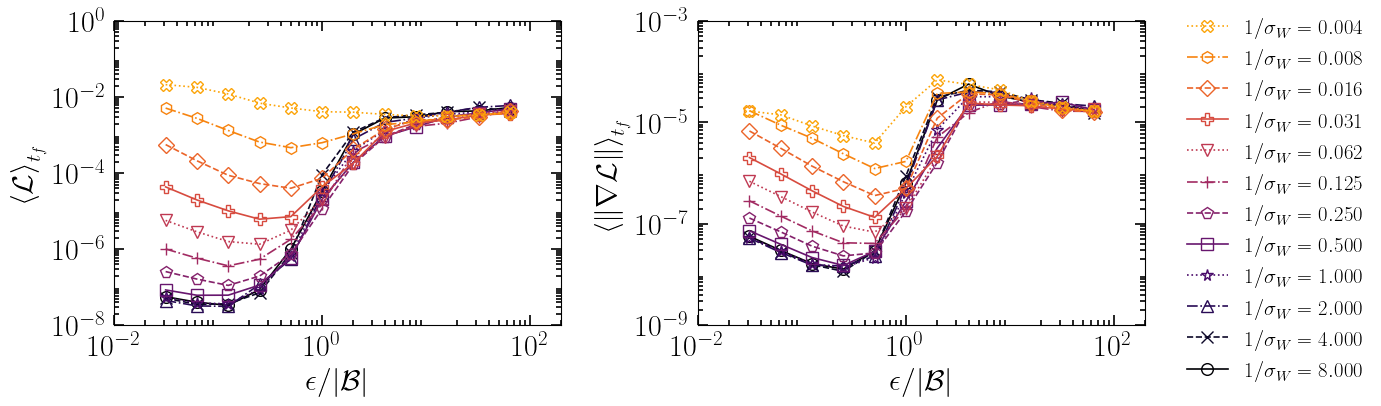

In [12]:
set_rc(scale=1.2)

n_fig = 2

cmap = plt.cm.inferno(np.linspace(0,0.8,n_eps))
fig, axs = plt.subplots(1, n_fig, figsize=(n_fig*get_rc()['W'], get_rc()['W']*get_rc()['r']))

for idx in range(n_eps):

    y_plot = loss_data[:,idx,:,-1]
    med, err = asym_err(y_plot, axis=0)

    axs[0].plot(el_data[0,:,1], med,
                color=cmap[idx], markevery=1,
                label=r"$1/\sigma_W = %3.3f$"%(1./epss[idx])
               )

    nice_style(axs[0], 
               xlim=(1e-2, 2e2),
               ylim=(1e-8, 1e0),
               xlabel=r"$\epsilon / |\mathcal{B}|$",
               ylabel=r"$\left\langle \mathcal{L} \right\rangle_{t_f}$",
               logx=True, logy=True,
              )

    y_plot = np.linalg.norm(dW_data[:,idx,:,-1], axis=(2,3))
    med, err = asym_err(y_plot, axis=(0))

    axs[1].plot(el_data[0,:,1], med,
                color=cmap[idx],
               )

    nice_style(axs[1],
               xlim=(1e-2, 2e2),
               ylim=(1e-9, 1e-3),
               xlabel=r"$\epsilon / |\mathcal{B}|$",
               ylabel=r"$\left\langle \lVert \nabla \mathcal{L} \rVert \right\rangle_{t_f}$",
               logx=True, logy=True
              )
    
lgd = fig.legend(bbox_to_anchor=(1.17, 0.955), fontsize=15, ncol=1, markerscale=1., reverse=True)
fig.savefig(plot_dir+"TS_phase_along_sig.pdf", bbox_extra_artists=(lgd,), bbox_inches='tight')
plt.show()

# Figure 4

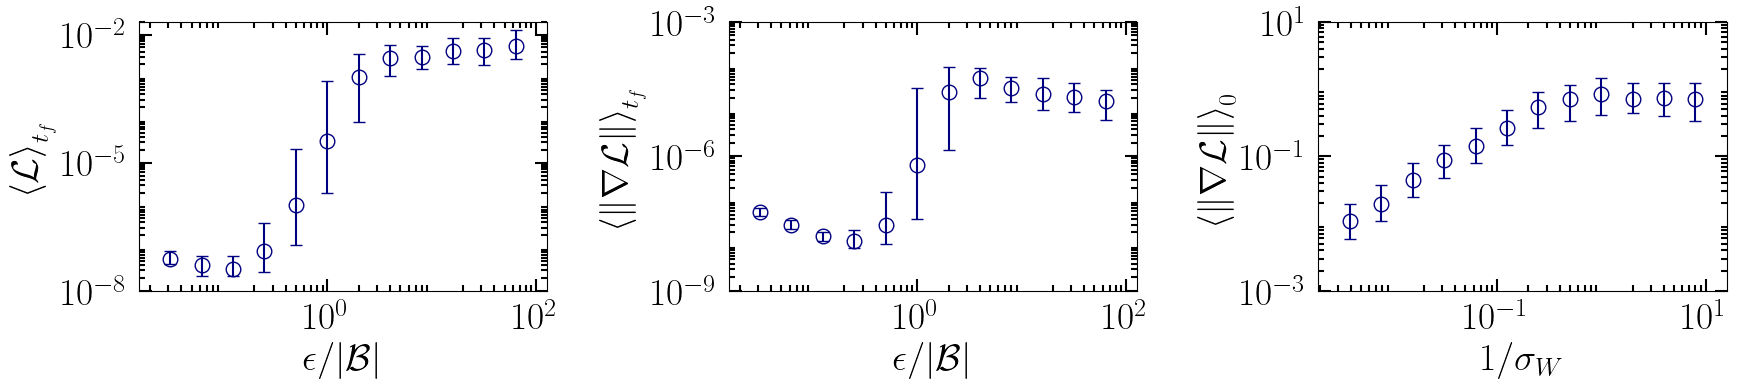

In [13]:
set_rc(scale=1.5)

n_fig = 3
fig, axs = plt.subplots(1, n_fig, figsize=(n_fig*get_rc()['W'], get_rc()['W']*get_rc()['r']))

y_plot = loss_data[:,0,:,-1]
med, err = asym_err(y_plot, axis=0)

axs[0].errorbar(el_data[0,:,1], med,
                yerr=err, ls='', marker='o', color='navy')

nice_style(axs[0], 
           xlim=(np.min(el_data[0,:,1])/2., np.max(el_data[0,:,1])*2),
           ylim=(1e-8, 2e-2),
           xlabel=r"$\epsilon / |\mathcal{B}|$",
           ylabel=r"$\left\langle \mathcal{L} \right\rangle_{t_f}$",
           logx=True, logy=True,
          )

y_plot = np.linalg.norm(np.abs(dW_data[:,0,:,-1]), axis=(2,3))
med, err = asym_err(y_plot, axis=(0))

axs[1].errorbar(el_data[0,:,1], med,
                yerr=err, ls='', marker='o', color='navy')

nice_style(axs[1],
           xlim=(np.min(el_data[0,:,1])/2., np.max(el_data[0,:,1])*2),
           ylim=(1e-9, 1e-3),
           xlabel=r"$\epsilon / |\mathcal{B}|$",
           ylabel=r"$\left\langle \lVert \nabla \mathcal{L} \rVert \right\rangle_{t_f}$",
           logx=True, logy=True
          )

y_plot = np.linalg.norm(np.abs(dW_data[:,:,0,0]), axis=(2,3))
med, err = asym_err(y_plot, axis=(0))

axs[2].errorbar(el_data[:,0,0], med,
             yerr=err, ls='', marker='o', color='navy')

nice_style(axs[2], logx=True, logy=True,
           xlim=(np.min(el_data[:,0,0])/2., np.max(el_data[:,0,0])*2),
           ylim=(1e-3, 1e1), 
           xlabel=r"$1/\sigma_W$", 
           ylabel=r"$\left\langle \lVert \nabla \mathcal{L} \rVert \right\rangle_{0}$"
          )

plt.savefig(plot_dir+"TS_ran_loss_grad.pdf")
plt.show()

# Figure 5

/Users/chanju/Library/CloudStorage/Dropbox/Lab/swansea/workspace/Git/global_chanju/global_chanju/paulplot/styles.py:51: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  ax.figure.tight_layout()


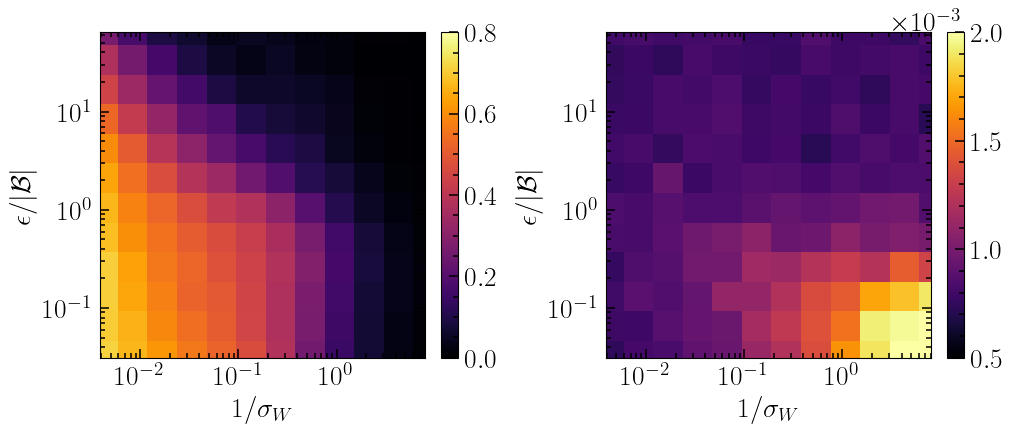

In [14]:
set_rc(scale=1.1)

n_fig = 2
fig, axs = plt.subplots(1, n_fig, figsize=(n_fig*get_rc()['W']*get_rc()['r'], get_rc()['W']*get_rc()['r']))

im = axs[0].pcolor(el_data[:, :, 0], el_data[:, :, 1], 
                   np.mean(q_time, axis=0), 
                   vmin = 0., vmax = 0.8,
                   cmap='inferno')

nice_style(axs[0], 
           ylim=(np.min(el_data[0,:,1]), np.max(el_data[0,:,1])),
           xlim=(np.min(el_data[:,0,0]), np.max(el_data[:,0,0])),
           xlabel=r"$1/\sigma_W$",
           ylabel=r"$\epsilon / |\mathcal{B}|$",
           logx=True, logy=True
          )

axins0 = inset_axes(axs[0],
                    width="5%",  # width: 5% of parent_bbox width
                    height="100%",  # height: 50%
                    loc="lower left",
                    bbox_to_anchor=(1.05, 0., 1, 1),
                    bbox_transform=axs[0].transAxes,
                    borderpad=0,
)
cb = fig.colorbar(im, cax=axins0, orientation="vertical", )

axs[0].set_aspect("equal")

im = axs[1].pcolor(el_data[:, :, 0], el_data[:, :, 1], 
                   np.mean(hs, axis=(0)), 
                   vmin = 0.5e-3, vmax = 2e-3,
                   cmap='inferno')

nice_style(axs[1], 
           ylim=(np.min(el_data[0,:,1]), np.max(el_data[0,:,1])),
           xlim=(np.min(el_data[:,0,0]), np.max(el_data[:,0,0])),
           xlabel=r"$1/\sigma_W$",
           ylabel=r"$\epsilon / |\mathcal{B}|$",
           logx=True, logy=True
          )

axins1 = inset_axes(axs[1],
                    width="5%",  # width: 5% of parent_bbox width
                    height="100%",  # height: 50%
                    loc="lower left",
                    bbox_to_anchor=(1.05, 0., 1, 1),
                    bbox_transform=axs[1].transAxes,
                    borderpad=0,
)

cb = fig.colorbar(im, cax=axins1, orientation="vertical", )
cb.formatter.set_powerlimits((0, 0))

axs[1].set_aspect("equal")

plt.subplots_adjust(left=0, right=0.98)

plt.savefig(plot_dir+"TS_ran_obs.pdf", 
            bbox_extra_artists=(axins0, axins1, ), 
            bbox_inches='tight')
plt.show()

# Figure 6

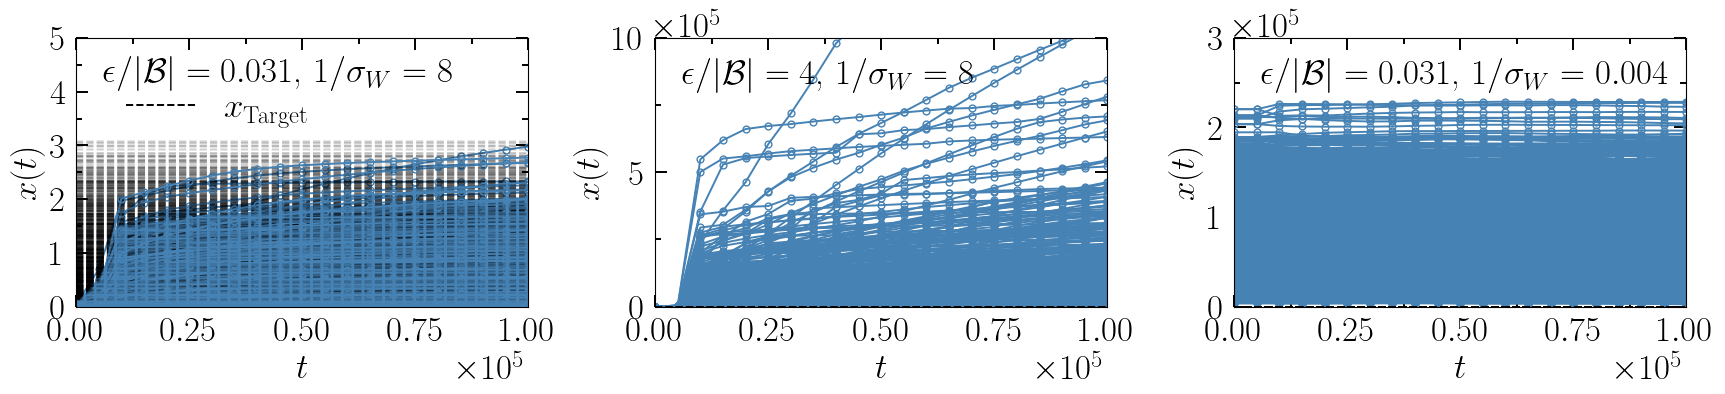

In [15]:
set_rc(scale=1.4)

n_fig = 3
fig, axs = plt.subplots(1, n_fig, 
                        figsize=(n_fig*get_rc()['W'], get_rc()['W']*get_rc()['r']))

# Ferro
eps_idx = 0
lr_idx = 0

phase_W = W_data[:, eps_idx, lr_idx]
phase_s = np.empty(shape=(n_data, n_save, K))

phase_Wt = Wt_data[:, eps_idx, lr_idx]
_, phase_st, _ = np.linalg.svd(phase_Wt)
for i in range(n_save):
    _, s_, _ = np.linalg.svd(phase_W[:, i])
    phase_s[:,i] = s_
    
x_plot = np.linspace(0, epochs, n_save)
axs[0].axhline(phase_st[-1][-1]**2, color='k', ls='--', label=r"$x_{\rm Target}$")

for i in range(n_data):
    axs[0].plot(x_plot, phase_s[i]**2, 
                color='steelblue', ls='-', marker='.', alpha=1.)
    for s_ in range(K):
        axs[0].axhline(phase_st[i][s_]**2, color='k', ls='--', alpha=0.1)
                
nice_style(axs[0],
           xlim=(0, epochs), ylim=(0, 5),
           xlabel=r"$t$",
           ylabel=r"$x (t)$",
           yticks=[0,1,2,3,4,5]
          )

axs[0].ticklabel_format(axis='both', style='sci', scilimits=(0,0))

# axs[0].legend(bbox_to_anchor=(0.47, 0.85)) # scale = 1.2
axs[0].legend(bbox_to_anchor=(0.041, 0.55),)

axs[0].text(0.06,0.87,
            transform=axs[0].transAxes,
            horizontalalignment='left', verticalalignment='center',
            color='k', 
            s=r"$\epsilon/|\mathcal{B}|=%.3f$, $1/\sigma_W = %1.0f$"%(el_data[eps_idx, lr_idx, 1], el_data[eps_idx, lr_idx, 0])
           )

# Para
eps_idx = 0
lr_idx = -5

phase_W = W_data[:, eps_idx, lr_idx]
phase_s = np.empty(shape=(n_data, n_save, K))

phase_Wt = Wt_data[:, eps_idx, lr_idx]
_, phase_st, _ = np.linalg.svd(phase_Wt)
for i in range(n_save):
    _, s_, _ = np.linalg.svd(phase_W[:, i])
    phase_s[:,i] = s_
    
for i in range(n_data):
    axs[1].plot(x_plot, phase_s[i]**2, 
             color='steelblue', ls='-', marker='.', alpha=1.)
    for s_ in range(K):
        axs[1].axhline(phase_st[i][s_]**2, color='k', ls='--', alpha=0.1)
        
axs[1].axhline(phase_st[-1][-1]**2, color='k', ls='--')
        
nice_style(axs[1],
           xlim=(0, epochs), ylim=(0, 1000000),
           xlabel=r"$t$",
           ylabel=r"$x (t)$",
          )

axs[1].ticklabel_format(axis='both', style='sci', scilimits=(5,5))

axs[1].text(0.06,0.86,
            transform=axs[1].transAxes,
            horizontalalignment='left', verticalalignment='center',
            color='k', 
            s=r"$\epsilon/|\mathcal{B}|=%1.f$, $1/\sigma_W = %1.0f$"%(el_data[eps_idx, lr_idx, 1], el_data[eps_idx, lr_idx, 0])
           )

# SG
eps_idx = -1
lr_idx = 0

phase_W = W_data[:, eps_idx, lr_idx]
phase_s = np.empty(shape=(n_data, n_save, K))

phase_Wt = Wt_data[:, eps_idx, lr_idx]
_, phase_st, _ = np.linalg.svd(phase_Wt)
for i in range(n_save):
    _, s_, _ = np.linalg.svd(phase_W[:, i])
    phase_s[:,i] = s_
    
for i in range(n_data):
    axs[2].plot(x_plot, phase_s[i]**2, 
             color='steelblue', ls='-', marker='.', alpha=1.)
    for s_ in range(K):
        axs[2].axhline(phase_st[i][s_]**2, color='k', ls='--', alpha=0.1)
        
axs[2].axhline(phase_st[-1][-1]**2, color='k', ls='--')
        
nice_style(axs[2],
           xlim=(0, epochs), ylim=(0, 300000),
           xlabel=r"$t$",
           ylabel=r"$x (t)$",
          )

axs[2].ticklabel_format(axis='both', style='sci', scilimits=(0,0))

axs[2].text(0.06,0.86,
            transform=axs[2].transAxes,
            horizontalalignment='left', verticalalignment='center',
            color='k', 
            s=r"$\epsilon/|\mathcal{B}|=%.3f$, $1/\sigma_W = %.3f$"%(el_data[eps_idx, lr_idx, 1], el_data[eps_idx, lr_idx, 0])
           )

plt.subplots_adjust(wspace=0.28)
plt.savefig(plot_dir+"TS_ran_eig_flow.pdf")

# Figure 7

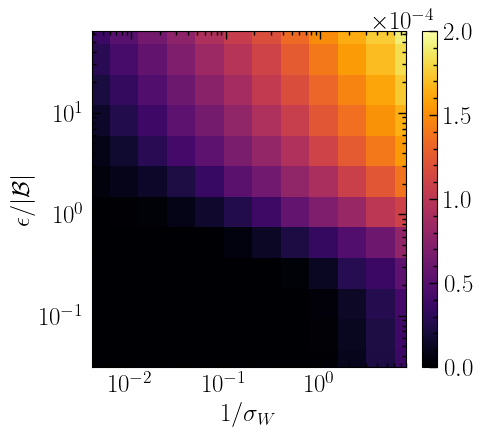

In [16]:
lyapunov_matrix = np.empty(shape=(n_eps, n_lr))

for i in range(n_eps):
    for j in range(n_lr):
        W_t = W_data[:, i, j]
        WWTt = np.einsum("stik, stjk -> stij", W_t, W_t)
        lbdt = np.sort(np.linalg.eigvals(WWTt))
        u_0 = (lbdt[:, 0] - np.roll(lbdt[:, 0], shift=1, axis=-1))[:,1:]
        u_t = (lbdt[:, -1] - np.roll(lbdt[:, -1], shift=1, axis=-1))[:,1:]

        u_0_mean = np.mean(u_0, axis=-1)
        u_t_mean = np.mean(u_t, axis=-1)
        max_lyapunov = np.mean(np.log(u_t_mean / u_0_mean)/ epochs, axis=0)
        lyapunov_matrix[i][j] = max_lyapunov

set_rc(scale=1)

colours = plt.cm.pink(np.linspace(0.4, 1, 3))
cmap = LinearSegmentedColormap.from_list(f'new_inferno', colours)

n_fig = 1
fig, axs = plt.subplots(1, n_fig, figsize=(n_fig*get_rc()['W']*get_rc()['r'], get_rc()['W']*get_rc()['r']))

im = axs.pcolor(el_data[:, :, 0], el_data[:, :, 1], 
                lyapunov_matrix,
                vmin=0, vmax=20/epochs,
                cmap='inferno')

nice_style(axs, 
           ylim=(np.min(el_data[0,:,1]), np.max(el_data[0,:,1])),
           xlim=(np.min(el_data[:,0,0]), np.max(el_data[:,0,0])),
           xlabel=r"$1/\sigma_W$",
           ylabel=r"$\epsilon / |\mathcal{B}|$",
           logx=True, logy=True
          )

axins = inset_axes(
    axs,
    width="5%",  # width: 5% of parent_bbox width
    height="100%",  # height: 50%
    loc="lower left",
    bbox_to_anchor=(1.05, 0., 1, 1),
    bbox_transform=axs.transAxes,
    borderpad=0,
)

cb = fig.colorbar(im, cax=axins, orientation="vertical", )
cb.formatter.set_powerlimits((0, 0))

plt.savefig(plot_dir+"TS_exp_dec.pdf", 
            bbox_extra_artists=(axins,), 
            bbox_inches='tight')
plt.show()

# Figure 8

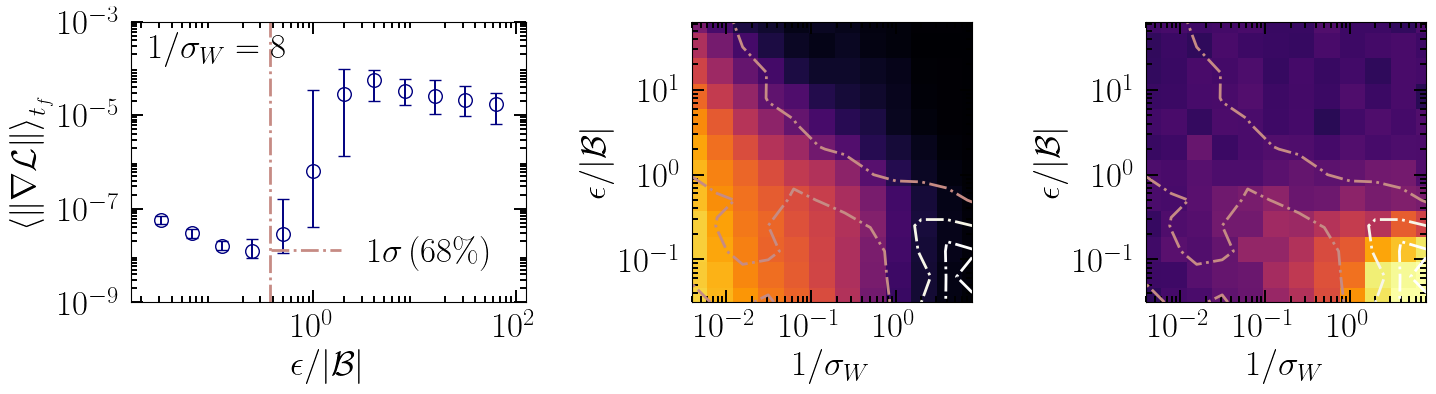

In [17]:
set_rc(scale=1.4)

colours = plt.cm.pink(np.linspace(0.4, 1, 3))
cmap = LinearSegmentedColormap.from_list(f'new_inferno', colours)

sig1 = 0.68
sig2 = 0.95
sig3 = 0.997

t_idx = np.max(np.where(limit_matrix_new[0] > sig1))
Tc1 = (lrs[t_idx] + lrs[t_idx+1]) / 4. / 2.
t_idx = np.max(np.where(limit_matrix_new[0] > sig2))
Tc2 = (lrs[t_idx] + lrs[t_idx+1]) / 4. / 2.
t_idx = np.max(np.where(limit_matrix_new[0] > sig3))
Tc3 = (lrs[t_idx] + lrs[t_idx+1]) / 4. / 2.

n_fig = 3
all_fig_w = get_rc()['W'] + 2*get_rc()['W']*get_rc()['r']
fig1_w = get_rc()['W'] / all_fig_w
fig2_w = get_rc()['W']*get_rc()['r'] / all_fig_w
fig, axs = plt.subplots(1, n_fig, 
                        figsize=(all_fig_w, get_rc()['W']*get_rc()['r']),
                        gridspec_kw={'width_ratios': [fig1_w, fig2_w, fig2_w]}
                       )


y_plot = np.linalg.norm(np.abs(dW_data[:,0,:,-1]), axis=(2,3))
med, err = asym_err(y_plot, axis=(0))

axs[0].errorbar(el_data[0,:,1], med,
                yerr=err, ls='', marker='o', color='navy')

axs[0].axvline(Tc1, ls='-.', color=colours[0], lw=2, label=r"$1\sigma \, ({0} \%) $".format(int(sig1*100)))

nice_style(axs[0],
           xlim=(np.min(el_data[0,:,1])/2., np.max(el_data[0,:,1])*2),
           ylim=(1e-9, 1e-3),
           xlabel=r"$\epsilon / |\mathcal{B}|$",
           ylabel=r"$\left\langle \lVert \nabla \mathcal{L} \rVert \right\rangle_{t_f}$",
           logx=True, logy=True
          )

axs[0].text(0.05, 0.90,
            transform=axs[0].transAxes,
            horizontalalignment='left', verticalalignment='center',
            color='k', 
            s=r"$1/\sigma_W = %.0f$"%(1./epss[0])
           )

axs[0].legend(loc='lower right')

#=====

im = axs[1].pcolor(el_data[:, :, 0], el_data[:, :, 1], 
                   np.mean(q_time, axis=(0)), 
                   vmin=0., vmax=0.8,
                   cmap='inferno')

CS = axs[1].contour(el_data[:, :, 0], el_data[:, :, 1], 
                    limit_matrix_new, levels=[sig1, sig2, sig3],
                    cmap=cmap, 
                    linestyles='-.')

plt.setp(CS.collections, linewidth=2.)

nice_style(axs[1], logx=True, logy=True,
           xlim=(np.min(el_data[:,0,0]), np.max(el_data[:,0,0])),
           ylim=(np.min(el_data[0,:,1]), np.max(el_data[0,:,1])), 
           xlabel=r"$1/\sigma_W$", 
           ylabel=r"$\epsilon / |\mathcal{B}|$"
          )

axs[1].set_aspect("equal")

#=====
im = axs[2].pcolor(el_data[:, :, 0], el_data[:, :, 1], 
                   np.mean(hs, axis=(0)), 
                   vmin=0.5e-3, vmax=2e-3,
                   cmap='inferno')

CS = axs[2].contour(el_data[:, :, 0], el_data[:, :, 1], 
                    limit_matrix_new, levels=[sig1, sig2, sig3],
                    cmap=cmap, 
                    linestyles='-.')

plt.setp(CS.collections, linewidth=2.)

nice_style(axs[2],
           xlim=(np.min(el_data[:,0,0]), np.max(el_data[:,0,0])),
           ylim=(np.min(el_data[0,:,1]), np.max(el_data[0,:,1])), 
           xlabel=r"$1/\sigma_W$",
           ylabel=r"$\epsilon / |\mathcal{B}|$",
           logx=True, logy=True
          )

axs[2].set_aspect("equal")


plt.savefig(plot_dir+"TS_ran_pred.pdf",
            bbox_inches='tight')
plt.show()

# Figure 9

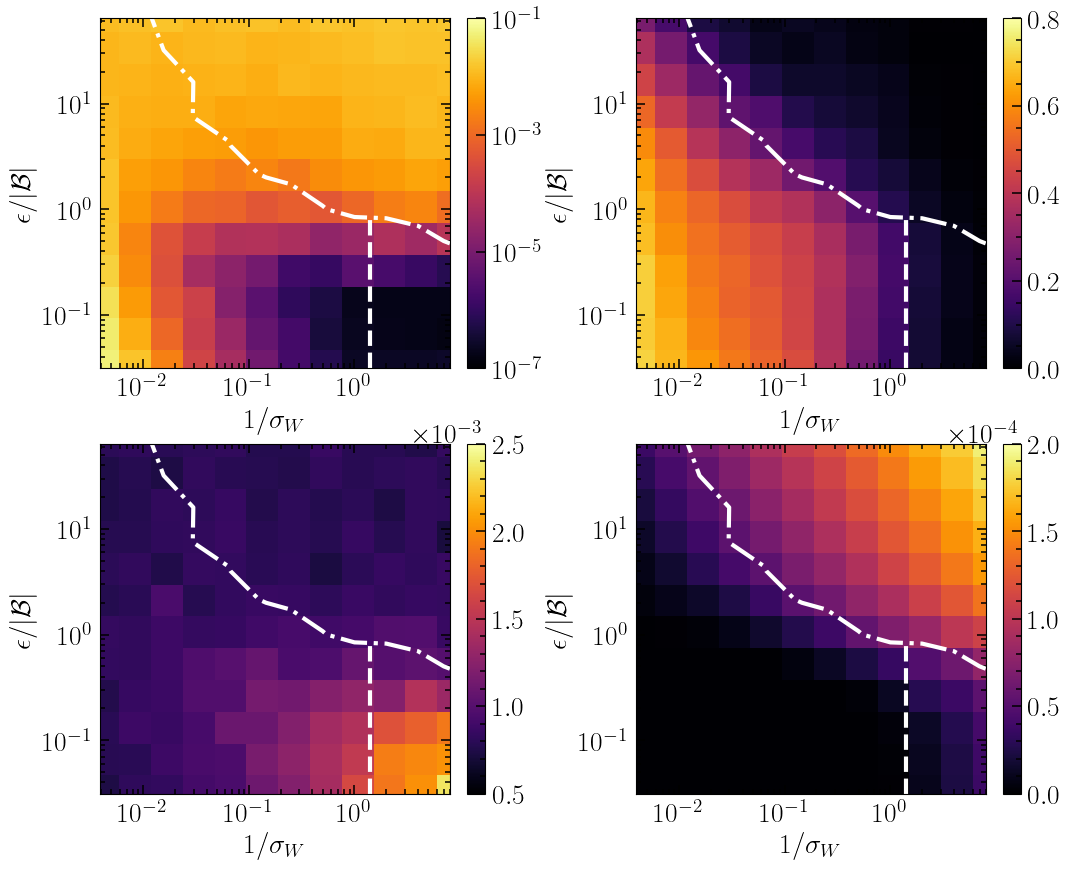

In [18]:
set_rc(scale=1.1)

masked_limit = np.ma.array(limit_matrix_new, mask = el_data[:, :, 1]*el_data[:, :, 0] <= 0.1)

n_fig = 2
fig, axs = plt.subplots(2, n_fig, figsize=(n_fig*get_rc()['W']*get_rc()['r'], n_fig*get_rc()['W']*get_rc()['r']))

im = axs[0,0].pcolor(el_data[:, :, 0], el_data[:, :, 1], 
                     np.mean((yt - y)**2, axis=(0, -1, -2)), 
                     norm=LogNorm(vmin=1e-7, vmax=1e-1),
                     cmap='inferno')

axins0 = inset_axes(axs[0,0],
                    width="5%",  # width: 5% of parent_bbox width
                    height="100%",  # height: 50%
                    loc="lower left",
                    bbox_to_anchor=(1.05, 0., 1, 1),
                    bbox_transform=axs[0,0].transAxes,
                    borderpad=0,
                   )

cb = fig.colorbar(im, cax=axins0, orientation="vertical", )

CS = axs[0,0].contour(el_data[:, :, 0], el_data[:, :, 1], 
                      masked_limit,
                      levels = [sig1],
                      colors = 'white',
                      linestyles='-.')

plt.setp(CS.collections, linewidth=3.)
axs[0,0].axvline(np.sqrt(2.), ymax=0.436, color='white', ls='--', lw=3.)

nice_style(axs[0,0], 
           ylim=(np.min(el_data[0,:,1]), np.max(el_data[0,:,1])),
           xlim=(np.min(el_data[:,0,0]), np.max(el_data[:,0,0])),
           xlabel=r"$1/\sigma_W$",
           ylabel=r"$\epsilon / |\mathcal{B}|$",
           logx=True, logy=True
          )

axs[0,0].set_aspect("equal")

#====

im = axs[0,1].pcolor(el_data[:, :, 0], el_data[:, :, 1], 
                     np.mean(q_time, axis=(0)), 
                     vmin=0., vmax=0.8,
                     cmap='inferno')

axins1 = inset_axes(axs[0,1],
                    width="5%",  # width: 5% of parent_bbox width
                    height="100%",  # height: 50%
                    loc="lower left",
                    bbox_to_anchor=(1.05, 0., 1, 1),
                    bbox_transform=axs[0,1].transAxes,
                    borderpad=0,
)

cb = fig.colorbar(im, cax=axins1, orientation="vertical", )


CS = axs[0,1].contour(el_data[:, :, 0], el_data[:, :, 1], 
                      masked_limit, 
                      levels = [sig1],
                      colors='white', 
                      linestyles='-.')

plt.setp(CS.collections, linewidth=3.)
axs[0,1].axvline(np.sqrt(2.), ymax=0.436, color='white', ls='--', lw=3.)

nice_style(axs[0,1], logx=True, logy=True,
           xlim=(np.min(el_data[:,0,0]), np.max(el_data[:,0,0])),
           ylim=(np.min(el_data[0,:,1]), np.max(el_data[0,:,1])), 
           xlabel=r"$1/\sigma_W$", 
           ylabel=r"$\epsilon / |\mathcal{B}|$"
          )

axs[0,1].set_aspect("equal")

#====

im = axs[1, 0].pcolor(
    el_data[:, :, 0], el_data[:, :, 1], 
    np.mean(hs, axis=(0)), 
    vmin=0.5e-3, vmax=2.5e-3,
    cmap='inferno')

axins2 = inset_axes(
    axs[1,0],
    width="5%",  # width: 5% of parent_bbox width
    height="100%",  # height: 50%
    loc="lower left",
    bbox_to_anchor=(1.05, 0., 1, 1),
    bbox_transform=axs[1,0].transAxes,
    borderpad=0,
)

cb = fig.colorbar(im, cax=axins2, orientation="vertical", )
cb.formatter.set_powerlimits((0, 0))

CS = axs[1,0].contour(
    el_data[:, :, 0], el_data[:, :, 1], 
    masked_limit, 
    levels = [sig1],
    colors='white', 
    linestyles='-.')

plt.setp(CS.collections, linewidth=3.)
axs[1,0].axvline(np.sqrt(2.), ymax=0.436, color='white', ls='--', lw=3.)

nice_style(axs[1,0],
           xlim=(np.min(el_data[:,0,0]), np.max(el_data[:,0,0])),
           ylim=(np.min(el_data[0,:,1]), np.max(el_data[0,:,1])), 
           xlabel=r"$1/\sigma_W$",
           ylabel=r"$\epsilon / |\mathcal{B}|$",
           logx=True, logy=True
          )

axs[1,0].set_aspect("equal")

#====

im = axs[1,1].pcolor(
    el_data[:, :, 0], el_data[:, :, 1], 
    lyapunov_matrix,
    vmin=0, vmax=20/epochs,
    cmap='inferno')

axins3 = inset_axes(
    axs[1,1],
    width="5%",  # width: 5% of parent_bbox width
    height="100%",  # height: 50%
    loc="lower left",
    bbox_to_anchor=(1.05, 0., 1, 1),
    bbox_transform=axs[1,1].transAxes,
    borderpad=0,
)

cb = fig.colorbar(im, cax=axins3, orientation="vertical", )
cb.formatter.set_powerlimits((0, 0))

CS = axs[1,1].contour(
    el_data[:, :, 0], el_data[:, :, 1], 
    masked_limit, 
    levels = [sig1],
    colors='white', 
    linestyles='-.')

plt.setp(CS.collections, linewidth=3.)
axs[1,1].axvline(np.sqrt(2.), ymax=0.436, color='white', ls='--', lw=3.)

nice_style(axs[1,1], logx=True, logy=True,
           xlim=(np.min(el_data[:,0,0]), np.max(el_data[:,0,0])),
           ylim=(np.min(el_data[0,:,1]), np.max(el_data[0,:,1])), 
           xlabel=r"$1/\sigma_W$", 
           ylabel=r"$\epsilon / |\mathcal{B}|$"
          )

axs[1,1].set_aspect("equal")

plt.subplots_adjust(right=1.16)

plt.savefig(plot_dir+"TS_ran_obs_all.pdf", 
            bbox_extra_artists=(axins0, axins1, axins2, axins3, ), 
            bbox_inches='tight')
plt.show()

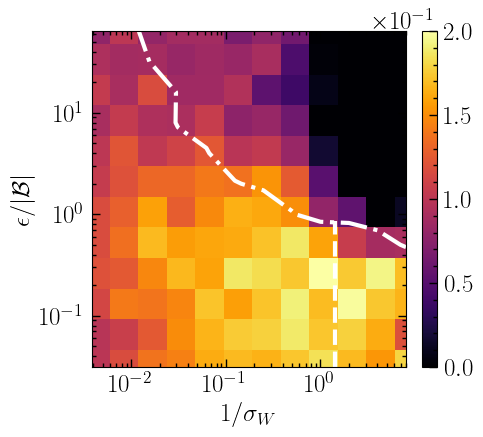

In [19]:
normhd = h / np.linalg.norm(h, axis=(-2), keepdims=True)
normsd = s / np.linalg.norm(s, axis=(-2), keepdims=True)
hsd = np.einsum("selni, selni -> sel", normhd, normsd) / K

set_rc(scale=1)

n_fig = 1
fig, axs = plt.subplots(1, n_fig, figsize=(n_fig*get_rc()['W']*get_rc()['r'], get_rc()['W']*get_rc()['r']))

im = axs.pcolor(
    el_data[:, :, 0], el_data[:, :, 1], 
    np.mean(hsd, axis=(0)), 
    vmin=0., vmax=0.2,
    cmap='inferno')

nice_style(axs, 
           ylim=(np.min(el_data[0,:,1]), np.max(el_data[0,:,1])),
           xlim=(np.min(el_data[:,0,0]), np.max(el_data[:,0,0])),
           xlabel=r"$1/\sigma_W$",
           ylabel=r"$\epsilon / |\mathcal{B}|$",
           logx=True, logy=True
          )

axins = inset_axes(
    axs,
    width="5%",  # width: 5% of parent_bbox width
    height="100%",  # height: 50%
    loc="lower left",
    bbox_to_anchor=(1.05, 0., 1, 1),
    bbox_transform=axs.transAxes,
    borderpad=0,
)

cb = fig.colorbar(im, cax=axins, orientation="vertical")
cb.formatter.set_powerlimits((0, 0))

CS = axs.contour(
    el_data[:, :, 0], el_data[:, :, 1], 
    masked_limit, 
    levels = [sig1],
    colors='white', 
    linestyles='-.')

plt.setp(CS.collections, linewidth=3.)
axs.axvline(np.sqrt(2.), ymax=0.436, color='white', ls='--', lw=3.)


plt.savefig(plot_dir+"TS_hsd.pdf", 
            bbox_extra_artists=(axins,), 
            bbox_inches='tight')
plt.show()